In [1]:
import os

# Set the environment variable
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import torch
from sbi.inference import SNLE
import matplotlib.pyplot as plt

2024-12-02 11:30:27.590032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 11:30:27.599009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 11:30:27.601668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 11:30:27.609409: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 11:30:28.0

# Beta

## generate theta and x

In [3]:
N = int(100e3)
# theta
alphas = torch.distributions.Uniform(0.1, 3.0).sample((N,))
betas = torch.distributions.Uniform(0.1, 3.0).sample((N,))
theta = torch.stack((alphas, betas), dim=1)
print(f'theta shape: {theta.shape}')

# x
x = torch.zeros(N, 1)
for i in range(N):
    alpha, beta = theta[i]
    beta_dist = torch.distributions.Beta(alpha, beta)
    x[i] = beta_dist.sample((1,))

print(f'x shape: {x.shape}')

theta shape: torch.Size([100000, 2])
x shape: torch.Size([100000, 1])


## SNLE

In [4]:
inference = SNLE()
likelihood_estimator = inference.append_simulations(theta, x).train()


/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 37 epochs.

## test likelihood

In [5]:
N_test = int(1e3)
x_test = torch.linspace(0,4, N_test).reshape(1, -1)
theta_test = torch.stack((7*torch.ones(N_test), 1*torch.ones(N_test)), dim=1)
print(f'theta_test shape: {theta_test.shape}')
print(f'x_test shape: {x_test.shape}')

loglike = likelihood_estimator.log_prob(x_test, theta_test)
print(f'loglike shape: {loglike.shape}')

theta_test shape: torch.Size([1000, 2])
x_test shape: torch.Size([1, 1000])
loglike shape: torch.Size([1, 1000])


## sampled

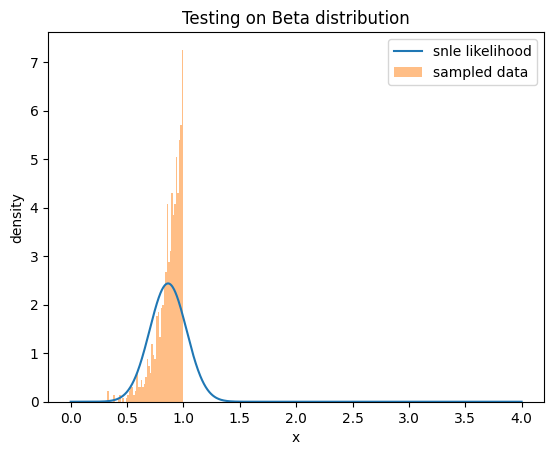

In [8]:
# generate data from theta_test
x_test_gen = torch.zeros(N_test, 1)
for i in range(N_test):
    alpha, beta = theta_test[i]
    beta_dist = torch.distributions.Beta(alpha, beta)
    x_test_gen[i] = beta_dist.sample((1,))
    
plt.plot(x_test.squeeze().detach().numpy(), loglike.exp().squeeze().detach().numpy(), label='snle likelihood')
plt.hist(x_test_gen.squeeze().detach().numpy(), bins=50, density=True, alpha=0.5, label='sampled data');
plt.xlabel('x')
plt.ylabel('density')
plt.legend();
plt.title('Testing on Beta distribution');
